---
jupytext:
  text_representation:
    extension: .md
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.16.4
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Lecture 4 - PubChem, REST API, and CAS Numbers

> This lecture builds carefully from the basics of PubChem URLs to more advanced lookups.  
> We use **short code blocks** with lots of comments and notes. At the end, we connect this with a real dataset of ligands using CAS numbers.  

```{contents}
:local:
:depth: 1
```

## Learning goals

- Understand PubChem as a data service (PUG-REST).  
- Learn to form URLs that return JSON or text data.  
- Resolve names to CIDs step by step.  
- Retrieve IUPAC names and SMILES representations.  
- Build reusable helper functions with error handling.  
- Practice with multiple compounds.  
- Use a real Excel sheet of ligands with CAS numbers to query PubChem.  

---

## 1. PubChem PUG-REST Basics

PubChem is not only a website — it provides an API called **PUG-REST**.  

- **Input**: name, CID, InChIKey, SMILES, or CAS number.  
- **Operation**: what property you want (CID, IUPAC, SMILES, etc.).  
- **Output**: JSON, XML, or TXT.  

Think of the URL as:  

```
https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/<input type>/<input value>/<operation>/<output format>
```

```{note}
Always read the URL as:  
1. Base: `https://pubchem.ncbi.nlm.nih.gov/rest/pug`  
2. Section: `compound` (since we work with compounds)  
3. Identifier type: `name`, `cid`, `smiles`, `cas`  
4. Action: what property to fetch  
5. Format: `JSON`, `XML`, `TXT`  
```

---

## 2. Setup

In [1]:
try:
    import requests
except Exception:
    %pip install requests
    import requests

from urllib.parse import quote_plus

---

## 3. From Name → CID

### 3.1 Form the URL

In [2]:
name = "acetaminophen"
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{quote_plus(name)}/cids/JSON"
print(url)

https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/acetaminophen/cids/JSON


```{note}
Try pasting this URL into your browser. You should see a JSON object with `"CID"`.  
```

### 3.2 Request and Parse

In [3]:
r = requests.get(url, timeout=30)
data = r.json()
print(data)

{'IdentifierList': {'CID': [1983]}}


Break it down:

In [4]:
print(data.keys())
print(data.get("IdentifierList", {}))

dict_keys(['IdentifierList'])
{'CID': [1983]}


In [5]:
cid_list = data.get("IdentifierList", {}).get("CID", [])
cid = cid_list[0]
print("CID:", cid)

CID: 1983


---

## 4. From CID → Properties

### 4.1 IUPAC Name

In [6]:
cid = 2244  # aspirin
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/JSON"
r = requests.get(url, timeout=30)
data = r.json()
print(data)

{'PropertyTable': {'Properties': [{'CID': 2244, 'IUPACName': '2-acetyloxybenzoic acid'}]}}


In [7]:
props = data["PropertyTable"]["Properties"][0]
print("IUPAC Name:", props["IUPACName"])

IUPAC Name: 2-acetyloxybenzoic acid


### 4.2 Canonical vs Isomeric SMILES

In [8]:
print("Canonical:", requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/TXT").text.strip())
print("Isomeric :", requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IsomericSMILES/TXT").text.strip())

Canonical: CC(=O)OC1=CC=CC=C1C(=O)O


Isomeric : CC(=O)OC1=CC=CC=C1C(=O)O


```{note}
- Canonical SMILES → standardized, but no stereochemistry.  
- Isomeric SMILES → includes stereochemistry/isotopes.  
```

---

## 5. Safer Functions

In [9]:
def safe_get_json(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.json()

def safe_get_text(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text.strip()

---

## 6. Convenience Functions

### 6.1 By Name

In [10]:
def pubchem_smiles_by_name(name, isomeric=True):
    enc = quote_plus(name.strip())
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/property/{kind}/TXT"
    smiles = safe_get_text(smi_url)

    cid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/cids/JSON"
    cid_list = safe_get_json(cid_url).get("IdentifierList", {}).get("CID", [])
    if not cid_list:
        raise ValueError("No CID found")
    cid = cid_list[0]

    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/TXT"
    iupac = safe_get_text(iupac_url)
    return {"name": name, "cid": cid, "smiles": smiles, "iupac": iupac}

In [11]:
pubchem_smiles_by_name("ibuprofen")

{'name': 'ibuprofen',
 'cid': 3672,
 'smiles': 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O',
 'iupac': '2-[4-(2-methylpropyl)phenyl]propanoic acid'}

### 6.2 By CID

In [12]:
def pubchem_smiles_by_cid(cid, isomeric=True):
    cid = int(cid)
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/{kind}/TXT"
    smiles = safe_get_text(smi_url)
    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/TXT"
    iupac = safe_get_text(iupac_url)
    return {"cid": cid, "smiles": smiles, "iupac": iupac}

In [13]:
pubchem_smiles_by_cid(2244)

{'cid': 2244,
 'smiles': 'CC(=O)OC1=CC=CC=C1C(=O)O',
 'iupac': '2-acetyloxybenzoic acid'}

---

## 7. Integration with RDKit

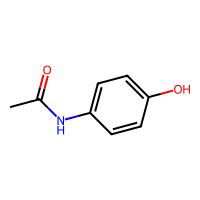

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw

res = pubchem_smiles_by_name("acetaminophen")
mol = Chem.MolFromSmiles(res["smiles"])
Draw.MolToImage(mol, size=(200,200))

```{admonition} Try
Compare the RDKit drawings for Canonical vs Isomeric SMILES of ibuprofen.  
```

---

## 8. Case Study: CAS Numbers from Excel

We have an inventory file:  

📂 [organic ligands inventory.xlsx](https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/organic%20ligands%20inventory.xlsx)

### 8.1 Load with pandas

In [15]:
import pandas as pd

url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/organic%20ligands%20inventory.xlsx"
df = pd.read_excel(url)
df.head()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

### 8.2 Query PubChem by CAS

PubChem accepts CAS numbers too.

In [ ]:
def pubchem_from_cas(cas, isomeric=True):
    enc = quote_plus(str(cas))
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/property/{kind}/TXT"
    smiles = safe_get_text(smi_url)
    cid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/cids/JSON"
    cid_list = safe_get_json(cid_url).get("IdentifierList", {}).get("CID", [])
    cid = cid_list[0] if cid_list else None
    return {"cas": cas, "cid": cid, "smiles": smiles}

In [ ]:
example_cas = df.loc[0,"CAS"]
pubchem_from_cas(example_cas)

### 8.3 Enrich the Dataset

In [ ]:
rows = []
for cas in df["CAS"].head(5):  # try first 5
    try:
        rows.append(pubchem_from_cas(cas))
    except Exception as e:
        rows.append({"cas": cas, "cid": None, "smiles": None})

pd.DataFrame(rows)

---

## 9. Exercises

```{admonition} Try
1. For each CAS in the first 10 rows, fetch CID and SMILES.  
2. Add MW and Purity from Excel into the same DataFrame.  
3. Use RDKit to compute LogP and TPSA for each compound.  
4. Compare experimental MW from Excel vs computed MW.  
```

---





## 4. PubChem and URL


```note
Goal: given a common name or a PubChem CID, get a SMILES string you can feed into RDKit.
```

### 4.1 Install and imports

In [ ]:
# Install requests if you do not have it
try:
    import requests
except Exception:
    %pip -q install requests
    import requests

from urllib.parse import quote_plus  

Instead of going to [PubChem’s main site](https://pubchem.ncbi.nlm.nih.gov) and manually searching for a compound, we can also use a **direct URL** to query PubChem’s REST API. This allows us to send structured requests and retrieve data in machine-readable formats such as JSON, XML, or plain text. 

The figure below illustrates the general workflow of PUG-REST: provide an input (like a compound name), choose an operation (for example, retrieving a CID), and specify the output format. Using URLs in this way not only automates lookups but also integrates PubChem data smoothly into code and analysis.




![PubChem PUG-REST Figure](https://iupac.github.io/WFChemCookbook/_images/pubchem_pugrest_fig1.jpg)

Here are some example URLs you can click and explore directly in a browser:
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin/cids/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin/cids/JSON): Returns the PubChem Compound ID (CID) for aspirin.
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/IUPACName/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/IUPACName/JSON): Returns the standardized IUPAC name.
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/CanonicalSMILES/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/CanonicalSMILES/JSON): Returns the canonical SMILES string representation.


```{note}
The key idea is that PubChem is not only a website but also a programmatic data service. A well-formed URL acts like a query to their database.
```

If you are interested in learning more about PubChem URL, please read:
- [IUPAC FAIR Chemistry Cookbook guide](https://iupac.github.io/WFChemCookbook/datasources/pubchem_pugrest1.html)


---

### 4.2 Resolve a **name** to a CID

In [ ]:
import requests
from urllib.parse import quote_plus

name = "acetaminophen"

# Step 1: resolve the name to one or more PubChem CIDs
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{quote_plus(name)}/cids/JSON"
print("URL:", url)  # helps debug if you get HTTP 400

r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

cid_list = data.get("IdentifierList", {}).get("CID", [])
if not cid_list:
    raise ValueError(f"No CID found for {name}")

cid = cid_list[0]  # take the first hit
print("CID:", cid)

```{note}
CID is PubChem’s numeric identifier for a molecule. Taking the first hit is simple and works well for common drugs.
Try to copy and paste the output URL from above copy to your browser and hit enter to see what it looks like!
```
Essentially, we first get the JSON format from the URL

In [ ]:
r = requests.get(url, timeout=30)
data = r.json()
data

Then we use `data.get()` to search for `"IdentifierList"`

In [ ]:
print(data.get("IdentifierList", {}))

---

### 4.3 Get properties from the CID

#### 4.3.1 Get the **IUPAC name**

In [ ]:
fields = "IUPACName"
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/{fields}/JSON"
print("URL:", url)

r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

props = data["PropertyTable"]["Properties"][0]
print("IUPAC:", props.get("IUPACName"))

```{note}
The IUPAC name is the standardized systematic name for the compound, defined by the International Union of Pure and Applied Chemistry.
```

Let's break it down again:

In [ ]:
data["PropertyTable"]

In [ ]:
data["PropertyTable"]["Properties"]

In [ ]:
data["PropertyTable"]["Properties"][0]

---

#### 4.3.2 Get the **Canonical SMILES**

Now, we can even condense everything within one line:

In [ ]:
print("Canonical SMILES:", requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/TXT").text.strip())

```{note}
Canonical SMILES is a normalized form of the molecule's SMILES string.  
It provides a unique representation but does not retain stereochemistry.
```

---

#### 4.3.3 Get the **Isomeric SMILES**
Similar:

In [ ]:
print("Isomeric SMILES:", requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IsomericSMILES/TXT").text.strip())

```{note}
Isomeric SMILES includes stereochemistry and isotopic information if PubChem has it.  
This is useful for distinguishing molecules that have the same atoms but different spatial arrangements.
```

---

### 4.4 Make it safe: minimal error handling

In [ ]:
import requests  # HTTP client
from urllib.parse import quote_plus  # safe URL encoding

def safe_get_json(url, timeout=30):  # fetch JSON safely
    r = requests.get(url, timeout=timeout)  # send request
    r.raise_for_status()  # raise if HTTP error
    return r.json()  # parse and return JSON

def safe_get_text(url, timeout=30):  # fetch plain text safely
    r = requests.get(url, timeout=timeout)  # send request
    r.raise_for_status()  # raise if HTTP error
    return r.text  # return raw text

```note
If you see HTTP 400, print the URL and check if the name was encoded.  
Timeouts keep notebooks from hanging.
```

---

## 4.5 Function: by **name**

In [ ]:
def pubchem_smiles_by_name(name, isomeric=True):  # look up by common name
    nm = str(name).strip()  # clean input
    if not nm:  # empty string check
        raise ValueError("Empty name")  # clear message
    enc = quote_plus(nm)  # URL encode the name
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"  # choose field
    # get SMILES as plain text
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/property/{kind}/TXT"  # TXT endpoint
    smiles = safe_get_text(smi_url).strip()  # fetch and strip whitespace
    # get CID via JSON
    cid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/cids/JSON"  # CID list
    cid_list = safe_get_json(cid_url).get("IdentifierList", {}).get("CID", [])  # pick from JSON
    if not cid_list:  # handle no hits
        raise ValueError(f"No CID found for name: {nm}")  # message
    cid = int(cid_list[0])  # first hit
    # get IUPAC name as text
    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/TXT"  # TXT endpoint
    iupac = safe_get_text(iupac_url).strip()  # fetch IUPAC
    return {"name": nm, "cid": cid, "smiles": smiles, "iupac": iupac}  # result dict

**Example**

In [ ]:
pubchem_smiles_by_name("ibuprofen")  # quick demo

---

## 4.6 Function: by **CID**

In [ ]:
def pubchem_smiles_by_cid(cid, isomeric=True):  # look up by CID
    try:
        cid_int = int(str(cid).strip())  # coerce to int
    except ValueError:
        raise ValueError(f"Bad CID: {cid}")  # clear message
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"  # choose field
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_int}/property/{kind}/TXT"  # TXT endpoint
    smiles = safe_get_text(smi_url).strip()  # fetch SMILES
    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_int}/property/IUPACName/TXT"  # TXT endpoint
    iupac = safe_get_text(iupac_url).strip()  # fetch IUPAC
    return {"cid": cid_int, "smiles": smiles, "iupac": iupac}  # result dict

**Example**

In [ ]:
pubchem_smiles_by_cid(2244)  # aspirin

---

## 4.7 Use with RDKit (short)

In [ ]:
from rdkit import Chem  # RDKit core
from rdkit.Chem import Draw  # drawing

res = pubchem_smiles_by_name("acetaminophen")  # fetch SMILES by name
mol = Chem.MolFromSmiles(res["smiles"])  # make molecule
Draw.MolToImage(mol, size=(180, 180))  # draw image

```{note}
If `MolFromSmiles` gives `None`, print the SMILES string and check for copy issues.
```

---



## 5. Save and export

In [ ]:
mol = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
print("canonical:", Chem.MolToSmiles(mol))
print("isomeric:", Chem.MolToSmiles(mol, isomericSmiles=True))

In [ ]:
# SDF with 2D coordinates
m = Chem.AddHs(mol)
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(m)
w = Chem.SDWriter("molecule.sdf")
w.write(m); w.close()
"Saved molecule.sdf"

In [ ]:
# PNG depiction
img = Draw.MolToImage(mol, size=(400, 300))
img.save("molecule.png")
"Saved molecule.png"

---

## 6. Quick reference

```{admonition} SMILES
- Atoms: upper case aliphatic, lower case aromatic
- Bonds: implicit single, =, #
- Branches: parentheses
- Rings: digits to open and close
- Charges: bracket the atom, e.g., [O-], [NH4+]
- Salts: separate parts with a dot
- E or Z: use slashes around the double bond
```

```{admonition} RDKit
- Parse: `Chem.MolFromSmiles`
- Draw: `Draw.MolToImage(..., includeAtomNumbers=True)`
- Hydrogens: `Chem.AddHs`
- Properties: `Descriptors.MolWt`, `Crippen.MolLogP`, `CalcNumHBA/HBD`, `CalcTPSA`
- Replace piece with piece: `Chem.ReplaceSubstructs(mol, findMol, repMol)`
- Salt split: `Chem.GetMolFrags(..., asMols=True)`
- Graph edit: `Chem.EditableMol`
- Save: `Chem.MolToSmiles`, `SDWriter`, PNG via `MolToImage(...).save(...)`
```

---

## 7. Glossary

```{glossary}
SMILES
  Text line notation for molecules. Example: ethanol is CCO.

aromatic
  Conjugated ring system represented with lower case atom symbols in SMILES, for example c1ccccc1.

CID
  PubChem Compound ID for a unique compound record.

sanitize
  RDKit process that checks valence, aromaticity, and stereochemistry.

descriptor
  Computed molecular property such as molecular weight or LogP.

EditableMol
  RDKit object that exposes low level atom and bond editing.
```

---

## 8. In-class activity

Each task mirrors the examples above. Fill in the `...` lines. Work in pairs. Solutions are in Section 9.

### 8.1 Read a SMILES and inspect

Given `smi = "O=C(O)c1ccccc1Cl"`.  
a) Draw with atom numbers.  
b) Count number of rings.  
c) Print the list of bonds with begin and end atom indices and bond orders.

```python
from rdkit import Chem
from rdkit.Chem import Draw

smi = ...  # TO DO

mol = Chem.MolFromSmiles(smi)
display(Draw.MolToImage(mol, size=(350, 250), includeAtomNumbers=True))

num_rings = ...   # TO DO: Chem.GetSSSR(mol)
print("rings:", num_rings)

for b in mol.GetBonds():
    print("bond", b.GetIdx(), b.GetBeginAtomIdx(), "-", b.GetEndAtomIdx(), "order", int(b.GetBondTypeAsDouble()))
```

---

### 8.2 Make a small properties table

Use names `["caffeine", "acetaminophen", "ibuprofen"]`. For each, fetch SMILES from PubChem, then compute MolWt, LogP, HBD, HBA, and TPSA.

```python
import pandas as pd
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

names = ...  # TO DO
rows = []
for nm in names:
    info = ...  # TO DO: pubchem_smiles_by_name
    smi = info["smiles"]
    m = Chem.MolFromSmiles(smi)
    rows.append({
        "name": nm,
        "smiles": smi,
        "MolWt": ...,
        "LogP": ...,
        "HBD": ...,
        "HBA": ...,
        "TPSA": ...
    })

pd.DataFrame(rows)
```

---

### 8.3 Replace chlorine with fluorine

Replace Cl with F in `Clc1ccc(cc1)C(=O)O` and print the result SMILES.

```python
find = Chem.MolFromSmiles(... )  # TO DO
put  = Chem.MolFromSmiles(... )  # TO DO
mol  = ... # TO DO
out  = ... # TO DO
print(Chem.MolToSmiles(out))
```

---

### 8.4 Add a methyl group with a graph edit

Add a methyl at atom index 2 of benzene.

```python
mol = Chem.MolFromSmiles("c1ccccc1")
em = Chem.EditableMol(mol)
# TO DO: add code
Draw.MolToImage(..., size=(350, 250))
```

---

### 8.5 PubChem lookup to SMILES and drawing

We often get inputs in different formats. Some may be PubChem CIDs (just digits) while others are SMILES strings.

Tasks:
1) For each name in `["446157", "2244", "CCO", "482752", "c1ccccc1"]`
2) Print a line: `name: ... CID=... SMILES=...`.
3) Draw each molecule.


```python
    mixed = [...]

for ... in ...:
    if ...:  # looks like CID
      ...
    else: 
      ... 
    print(...)
    mol = Chem.MolFromSmiles(...)
    display(Draw.MolToImage(mol, size=(100, 100)))

```

```{note} Hint:
Try `isdigit()` to distinguish between cid-like input and SMILES
```
---